In [1]:
def read_data(filename):
    with open(filename,'r',encoding = 'UTF8') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]
    return data

In [2]:
train_data = read_data("D:\\nsmc-master\\ratings_train.txt")
test_data = read_data("D:\\nsmc-master\\ratings_test.txt")

Virtual devices cannot be modified after being initialized


In [3]:
from konlpy.tag import Okt # konlpy.tag = 형태소 분석 및 품사 태깅

In [4]:
okt = Okt()
print(okt.pos(u'이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요'))

[('이', 'Noun'), ('밤', 'Noun'), ('그날', 'Noun'), ('의', 'Josa'), ('반딧불', 'Noun'), ('을', 'Josa'), ('당신', 'Noun'), ('의', 'Josa'), ('창', 'Noun'), ('가까이', 'Noun'), ('보낼게요', 'Verb')]


In [5]:
import json
import os
from pprint import pprint

In [6]:
def tokenize(doc):
    return['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]
# norm -> 정규화 : 그래욬-> 그래요, stem -> 근사화 : 그래요 -> 그렇다

In [7]:
if os.path.isfile('train_docs.json'):
    with open('train_docs.json',encoding="UTF-8")as f:
        train_docs = json.load(f)
    with open('test_docs.json',encoding="UTF-8")as f:
        test_docs = json.load(f)
else:
    train_docs = [(tokenize(row[1]),row[2]) for row in train_data]
    test_docs = [(tokenize(row[1]),row[2]) for row in test_data]
    with open('train_docs.json','w',encoding="UTF-8")as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('test_docs.json','w',encoding="UTF-8")as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")
        


In [8]:
pprint(train_docs[0])

[['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증나다/Adjective',
  '목소리/Noun'],
 '0']


In [9]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2159921


In [10]:
import nltk #natural langauge tool kit - 자연어처리
text = nltk.Text(tokens,name='NMSC')

print(len(text.tokens)) #전체토큰의 수

print(len(set(text.tokens))) #중복을 제외한 토큰의 수

2159921
49895


In [11]:
pprint(text.vocab().most_common(10)) #가장 많이나오는 단어출력

[('./Punctuation', 67778),
 ('영화/Noun', 50818),
 ('하다/Verb', 41209),
 ('이/Josa', 38540),
 ('보다/Verb', 38538),
 ('의/Josa', 30188),
 ('../Punctuation', 29055),
 ('가/Josa', 26627),
 ('에/Josa', 26468),
 ('을/Josa', 23118)]


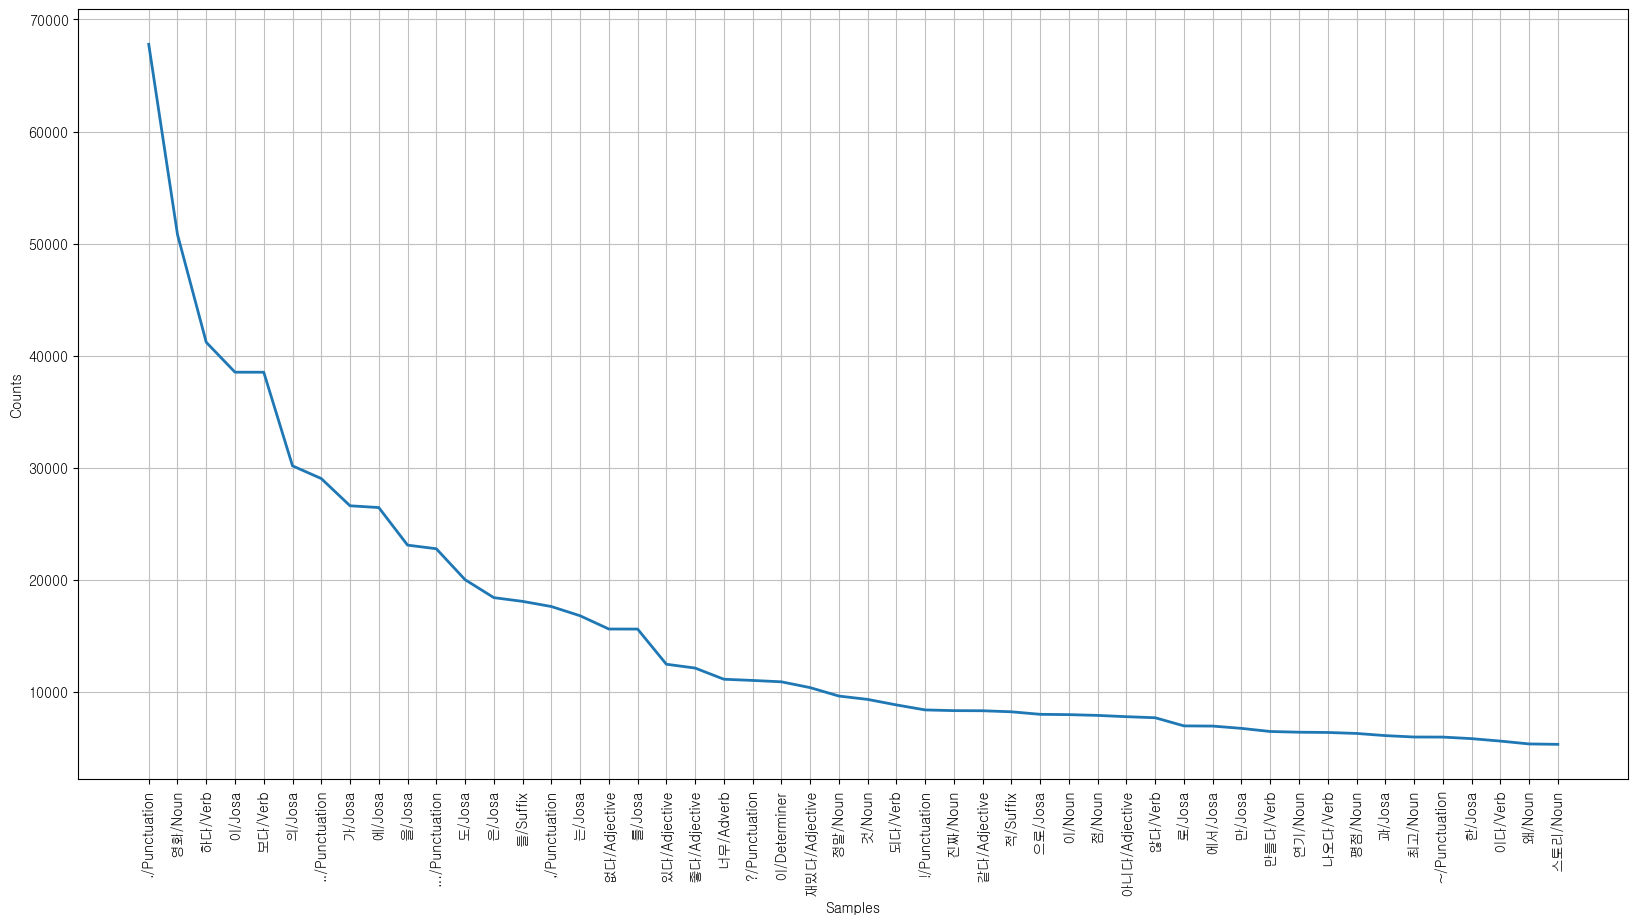

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [12]:
# 가장 많이 나오는 단어 그래프로 출력
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc # 한글 폰트불러오기

font_fname = 'c:/windows/fonts/gulim.ttc'# <-window
# 리눅스 -> /Library/Fonts/AppleGothic.ttf
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font',family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

In [37]:
selected_words = [f[0] for f in text.vocab().most_common(10000)]
# sample 크기가 너무 크면 밑에 메모리 오류로 실행이 안됨 5000까지는 돌아감
def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _,c in train_docs]
test_y = [c for _, c in test_docs]

In [38]:
# 데이터를 float형으로 변환
import numpy as np

x_train = np.array(train_x).astype('float32')
x_test = np.array(test_x).astype('float32')

y_train = np.array(train_y).astype('float32')
y_test = np.array(test_y).astype('float32')

In [52]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(5000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr=0.001),
             loss = losses.binary_crossentropy, # 손실 함수
             metrics = [metrics.binary_accuracy])

model.fit(x_train, y_train,epochs=10,batch_size=128) # 에포크 = 10, 배치 사이즈 = 512
results = model.evaluate(x_test,y_test)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [24]:
results

[0.3830094039440155, 0.8466600179672241]

In [25]:
def predict_pos_neg(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.array(tf).astype('float32'),axis=0)
    score = float(model.predict(data))
    if(score>0.5):
        print("[{}]는 {:2f}% 확률로 긍정입니다.\n".format(review,score*100))
    else:
        print("[{}]는 {:2f}% 확률로 부정입니다.\n".format(review,(1-score)*100))

In [36]:
predict_pos_neg("초반은 재미없었지만 후반은 너무 재밌음 이시대 최고의 영화.")

1/1 [==============================] - 0s 12ms/step
[초반은 재미없었지만 후반은 너무 재밌음 이시대 최고의 영화.]는 67.320737% 확률로 부정입니다.



[0.3830094039440155, 0.8466600179672241]